# 1. Data preparation

In [ ]:
from urllib import request

filenames = ["train-images-idx3-ubyte.gz",
             "train-labels-idx1-ubyte.gz",
             "t10k-images-idx3-ubyte.gz",
             "t10k-labels-idx1-ubyte.gz"]

folder = 'data_fashion_mnist/'
base_url = "http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/"
for name in filenames:
    print("Downloading " + name + "...")

    request.urlretrieve(base_url + name, folder + name)

In [ ]:
import numpy as np
import gzip


with gzip.open('data_fashion_mnist/train-images-idx3-ubyte.gz', 'rb') as f:
    X_train = np.frombuffer(f.read(), np.uint8, offset=16).reshape(-1, 28*28)

with gzip.open('data_fashion_mnist/t10k-images-idx3-ubyte.gz', 'rb') as f:
    X_test = np.frombuffer(f.read(), np.uint8, offset=16).reshape(-1, 28*28)

with gzip.open('data_fashion_mnist/train-labels-idx1-ubyte.gz', 'rb') as f:
    y_train = np.frombuffer(f.read(), np.uint8, offset=8)

with gzip.open('data_fashion_mnist/t10k-labels-idx1-ubyte.gz', 'rb') as f:
    y_test = np.frombuffer(f.read(), np.uint8, offset=8)


# check data
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(60000, 784)
(60000,)
(10000, 784)
(10000,)


# Tiếp cận 2

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import gzip

# Khúc này em bị khờ biết là bị overwriting mà không đặt biến khác mà đi copy lại, được cái nhanh :))
with gzip.open('data_fashion_mnist/train-images-idx3-ubyte.gz', 'rb') as f:
    X_train = np.frombuffer(f.read(), np.uint8, offset=16).reshape(-1, 28*28)

with gzip.open('data_fashion_mnist/t10k-images-idx3-ubyte.gz', 'rb') as f:
    X_test = np.frombuffer(f.read(), np.uint8, offset=16).reshape(-1, 28*28)

with gzip.open('data_fashion_mnist/train-labels-idx1-ubyte.gz', 'rb') as f:
    y_train = np.frombuffer(f.read(), np.uint8, offset=8)

with gzip.open('data_fashion_mnist/t10k-labels-idx1-ubyte.gz', 'rb') as f:
    y_test = np.frombuffer(f.read(), np.uint8, offset=8)


N = 60000
X_train = np.hstack([X_train, np.ones((N, 1))])
d = int(X_train.shape[1])
k = np.unique(y_train).shape[0]

# one_hot
def convert_one_hot(y, k):
    one_hot = np.zeros((len(y), k))
    y = y.astype(int)
    one_hot[np.arange(len(y)), y] = 1
    return one_hot


theta = 0.01 * np.random.randn(d, k)

learning_rate = 0.01
losses = []
accs = []
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []
max_epoch = 100
m = 5000


def predict(xi, theta):
    z = xi.dot(theta)
    exp_z = np.exp(z - np.max(z, axis=1, keepdims=True))
    y_hat = exp_z / np.sum(exp_z, axis=1, keepdims=True)
    return np.argmax(y_hat, axis=1)


def evaluate(X_test_data, y_test_data, theta, k):
    # Đánh giá bộ data test cập nhật từng epoch để vẽ plot test
    X_test_biased = np.hstack([X_test_data, np.ones((X_test_data.shape[0], 1))])

    # Compute predict
    preds = predict(X_test_biased, theta)

    # Compute accuracy
    accuracy = (preds == y_test_data.astype(int)).mean() * 100

    # Compute loss
    z = X_test_biased.dot(theta)
    exp_z = np.exp(z - np.max(z, axis=1, keepdims=True))
    y_hat = exp_z / np.sum(exp_z, axis=1, keepdims=True)
    y_test_one_hot = convert_one_hot(y_test_data, k)


    test_loss = -np.mean(np.sum(y_test_one_hot * np.log(y_hat + 1e-10), axis=1))
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)

    return test_loss, accuracy


# Training loop
for epoch in range(max_epoch):
    shuffled_indices = np.random.permutation(N)
    X_b_shuffled     = X_train[shuffled_indices]
    y_shuffled       = y_train_orig[shuffled_indices]

    running_loss = 0.0
    running_correct_samples = 0
    total_samples = 0

    num_batches = N // m

    for i in range(0, N, m):
        xi = X_b_shuffled[i:i + m]
        yi = y_shuffled[i:i + m]
        yi_one_hot = convert_one_hot(yi, k)


        z = xi.dot(theta)
        exp_z = np.exp(z - np.max(z, axis=1, keepdims=True))
        y_hat = exp_z / np.sum(exp_z, axis=1, keepdims=True)

        # cross-entropy
        batch_loss = -np.sum(yi_one_hot * np.log(y_hat + 1e-10), axis=1)
        mean_batch_loss = np.mean(batch_loss)
        losses.append(mean_batch_loss)

        # Tổng mean batch losses
        running_loss += mean_batch_loss

        # Compute batch accuracy
        preds = predict(xi, theta)
        batch_correct_samples = (preds == yi.astype(int)).sum() # Count correct predictions
        running_correct_samples += batch_correct_samples
        total_samples += len(yi) # Add number of samples in the batch


        # Compute đạo hàm
        gradient = xi.T.dot((y_hat - yi_one_hot)) / yi_one_hot.shape[0]

        # Cập nhật tham số
        theta -= learning_rate * gradient

        batch_accuracy = batch_correct_samples / len(yi)
        accs.append(batch_accuracy)


    # Evalute
    epoch_accuracy = 100 * running_correct_samples / total_samples
    epoch_loss = running_loss / num_batches
    test_loss, test_accuracy = evaluate(X_test_orig, y_test_orig, theta, k)
    print(f"Epoch [{epoch + 1}/{max_epoch}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%, Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")


    # Store
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_accuracy)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)

Epoch [1/100], Loss: 16.3703, Accuracy: 28.35%, Test Loss: 11.7040, Test Accuracy: 49.13%
Epoch [2/100], Loss: 10.2886, Accuracy: 55.24%, Test Loss: 7.8639, Test Accuracy: 65.76%
Epoch [3/100], Loss: 8.4524, Accuracy: 63.19%, Test Loss: 8.1069, Test Accuracy: 64.73%
Epoch [4/100], Loss: 7.0870, Accuracy: 69.11%, Test Loss: 6.4680, Test Accuracy: 71.84%
Epoch [5/100], Loss: 6.9018, Accuracy: 69.93%, Test Loss: 8.0184, Test Accuracy: 65.07%
Epoch [6/100], Loss: 6.9319, Accuracy: 69.81%, Test Loss: 8.2036, Test Accuracy: 64.30%
Epoch [7/100], Loss: 7.2695, Accuracy: 68.35%, Test Loss: 7.5907, Test Accuracy: 66.94%
Epoch [8/100], Loss: 6.1826, Accuracy: 73.02%, Test Loss: 6.7593, Test Accuracy: 70.48%
Epoch [9/100], Loss: 6.3272, Accuracy: 72.41%, Test Loss: 6.5291, Test Accuracy: 71.56%
Epoch [10/100], Loss: 6.1203, Accuracy: 73.32%, Test Loss: 5.2948, Test Accuracy: 76.93%
Epoch [11/100], Loss: 6.4844, Accuracy: 71.73%, Test Loss: 6.0492, Test Accuracy: 73.63%
Epoch [12/100], Loss: 5.807

<ipython-input-25-69b5c4dcfb7a>:9: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


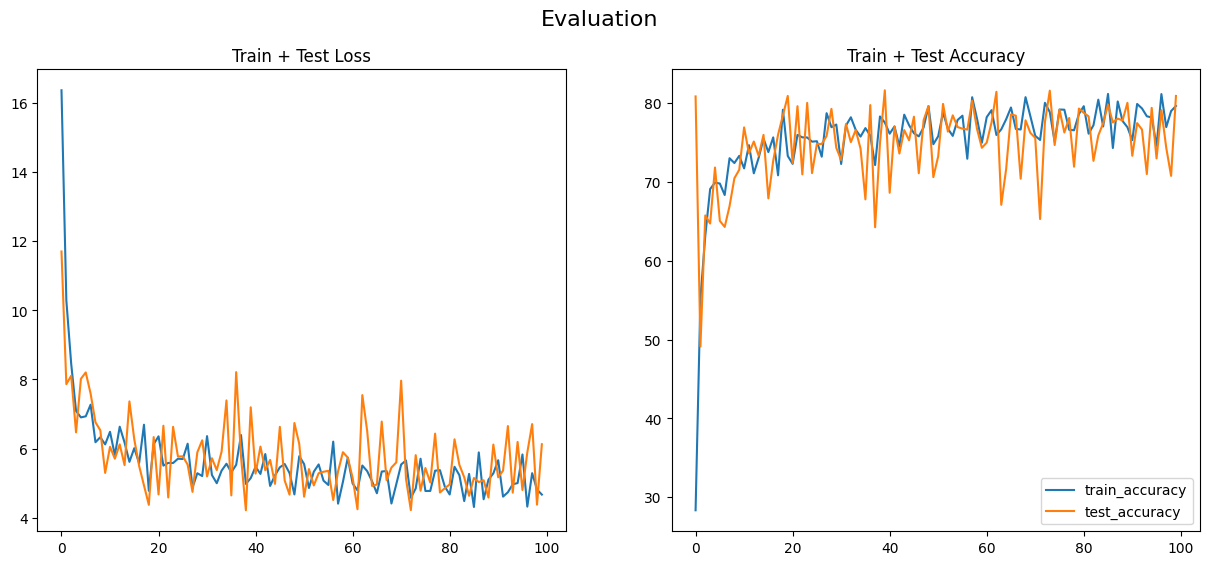

In [ ]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(15, 6))
fig.suptitle("Evaluation", fontsize=16)
x_axis1 = list(range(epoch+1))
axes[0].plot(x_axis1, train_losses,  label='train_losses')
axes[0].plot(x_axis1, test_losses, label='test_losses')
axes[0].set_title("Train + Test Loss")
plt.legend()

x_axis1 = list(range(epoch+1))
axes[1].plot(train_accuracies, label='train_accuracy')
axes[1].plot(test_accuracies, label='test_accuracy')
axes[1].set_title("Train + Test Accuracy")
plt.legend()

plt.show()

## Giảm lr


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import gzip

# Khúc này em bị khờ biết là bị overwriting mà không đặt biến khác mà đi copy lại, được cái nhanh :))
with gzip.open('data_fashion_mnist/train-images-idx3-ubyte.gz', 'rb') as f:
    X_train = np.frombuffer(f.read(), np.uint8, offset=16).reshape(-1, 28*28)

with gzip.open('data_fashion_mnist/t10k-images-idx3-ubyte.gz', 'rb') as f:
    X_test = np.frombuffer(f.read(), np.uint8, offset=16).reshape(-1, 28*28)

with gzip.open('data_fashion_mnist/train-labels-idx1-ubyte.gz', 'rb') as f:
    y_train = np.frombuffer(f.read(), np.uint8, offset=8)

with gzip.open('data_fashion_mnist/t10k-labels-idx1-ubyte.gz', 'rb') as f:
    y_test = np.frombuffer(f.read(), np.uint8, offset=8)


N = 60000
X_train = np.hstack([X_train, np.ones((N, 1))])
d = int(X_train.shape[1])
k = np.unique(y_train).shape[0]

# one_hot
def convert_one_hot(y, k):
    one_hot = np.zeros((len(y), k))
    y = y.astype(int)
    one_hot[np.arange(len(y)), y] = 1
    return one_hot


theta = 0.01 * np.random.randn(d, k)

learning_rate = 0.00001   # thay mỗi dòng này
losses = []
accs = []
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []
max_epoch = 100
m = 5000


def predict(xi, theta):
    z = xi.dot(theta)
    exp_z = np.exp(z - np.max(z, axis=1, keepdims=True))
    y_hat = exp_z / np.sum(exp_z, axis=1, keepdims=True)
    return np.argmax(y_hat, axis=1)


def evaluate(X_test_data, y_test_data, theta, k):
    # Đánh giá bộ data test cập nhật từng epoch để vẽ plot test
    X_test_biased = np.hstack([X_test_data, np.ones((X_test_data.shape[0], 1))])

    # Compute predict
    preds = predict(X_test_biased, theta)

    # Compute accuracy
    accuracy = (preds == y_test_data.astype(int)).mean() * 100

    # Compute loss
    z = X_test_biased.dot(theta)
    exp_z = np.exp(z - np.max(z, axis=1, keepdims=True))
    y_hat = exp_z / np.sum(exp_z, axis=1, keepdims=True)
    y_test_one_hot = convert_one_hot(y_test_data, k)


    test_loss = -np.mean(np.sum(y_test_one_hot * np.log(y_hat + 1e-10), axis=1))
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)

    return test_loss, accuracy


# Training loop
for epoch in range(max_epoch):
    shuffled_indices = np.random.permutation(N)
    X_b_shuffled     = X_train[shuffled_indices]
    y_shuffled       = y_train_orig[shuffled_indices]

    running_loss = 0.0
    running_correct_samples = 0
    total_samples = 0

    num_batches = N // m

    for i in range(0, N, m):
        xi = X_b_shuffled[i:i + m]
        yi = y_shuffled[i:i + m]
        yi_one_hot = convert_one_hot(yi, k)


        z = xi.dot(theta)
        exp_z = np.exp(z - np.max(z, axis=1, keepdims=True))
        y_hat = exp_z / np.sum(exp_z, axis=1, keepdims=True)

        # cross-entropy
        batch_loss = -np.sum(yi_one_hot * np.log(y_hat + 1e-10), axis=1)
        mean_batch_loss = np.mean(batch_loss)
        losses.append(mean_batch_loss)

        # Tổng mean batch losses
        running_loss += mean_batch_loss

        # Compute batch accuracy
        preds = predict(xi, theta)
        batch_correct_samples = (preds == yi.astype(int)).sum() # Count correct predictions
        running_correct_samples += batch_correct_samples
        total_samples += len(yi) # Add number of samples in the batch


        # Compute đạo hàm
        gradient = xi.T.dot((y_hat - yi_one_hot)) / yi_one_hot.shape[0]

        # Cập nhật tham số
        theta -= learning_rate * gradient

        batch_accuracy = batch_correct_samples / len(yi)
        accs.append(batch_accuracy)


    # Evalute
    epoch_accuracy = 100 * running_correct_samples / total_samples
    epoch_loss = running_loss / num_batches
    test_loss, test_accuracy = evaluate(X_test_orig, y_test_orig, theta, k)
    print(f"Epoch [{epoch + 1}/{max_epoch}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%, Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")


    # Store
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_accuracy)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)

Epoch [1/100], Loss: 13.6496, Accuracy: 18.55%, Test Loss: 10.4104, Test Accuracy: 26.91%
Epoch [2/100], Loss: 9.0115, Accuracy: 32.81%, Test Loss: 7.7840, Test Accuracy: 38.25%
Epoch [3/100], Loss: 7.0431, Accuracy: 42.34%, Test Loss: 6.5212, Test Accuracy: 45.33%
Epoch [4/100], Loss: 6.0640, Accuracy: 48.10%, Test Loss: 5.7893, Test Accuracy: 49.76%
Epoch [5/100], Loss: 5.4851, Accuracy: 51.72%, Test Loss: 5.3251, Test Accuracy: 52.61%
Epoch [6/100], Loss: 5.0811, Accuracy: 54.28%, Test Loss: 5.0003, Test Accuracy: 54.21%
Epoch [7/100], Loss: 4.7759, Accuracy: 56.19%, Test Loss: 4.7125, Test Accuracy: 56.23%
Epoch [8/100], Loss: 4.5276, Accuracy: 57.66%, Test Loss: 4.4913, Test Accuracy: 57.71%
Epoch [9/100], Loss: 4.3253, Accuracy: 58.99%, Test Loss: 4.3161, Test Accuracy: 58.69%
Epoch [10/100], Loss: 4.1570, Accuracy: 60.09%, Test Loss: 4.1427, Test Accuracy: 59.90%
Epoch [11/100], Loss: 4.0065, Accuracy: 61.09%, Test Loss: 4.0034, Test Accuracy: 60.55%
Epoch [12/100], Loss: 3.8687

<ipython-input-29-69b5c4dcfb7a>:9: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


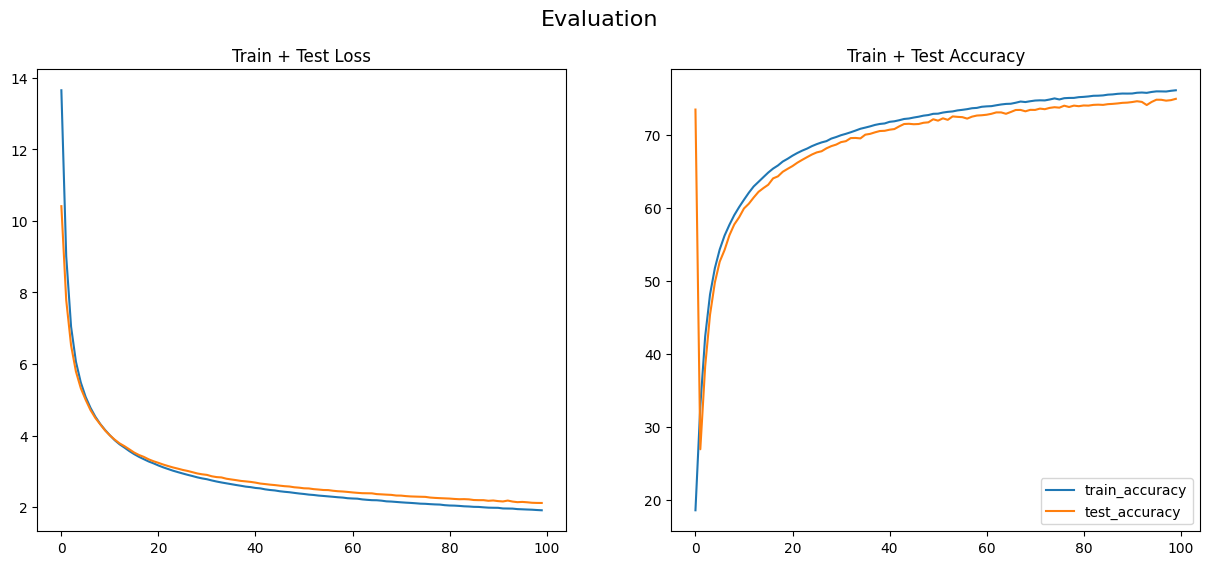

In [ ]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(15, 6))
fig.suptitle("Evaluation", fontsize=16)
x_axis1 = list(range(epoch+1))
axes[0].plot(x_axis1, train_losses,  label='train_losses')
axes[0].plot(x_axis1, test_losses, label='test_losses')
axes[0].set_title("Train + Test Loss")
plt.legend()

x_axis1 = list(range(epoch+1))
axes[1].plot(train_accuracies, label='train_accuracy')
axes[1].plot(test_accuracies, label='test_accuracy')
axes[1].set_title("Train + Test Accuracy")
plt.legend()

plt.show()

# Tiếp cận 3


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


data = pd.read_csv("Iris.csv")
data = data.to_numpy()
X = data[:,2:4]
Y = data[:,4]

N = 150
X = np.hstack([X.reshape(-1,2), np.ones((N, 1))])
d = int(X.shape[1])
k = np.unique(Y).shape[0]

# one_hot
def convert_one_hot(y, k):
    one_hot = np.zeros((len(y), k))
    y = y.astype(int)
    one_hot[np.arange(len(y)), y] = 1
    return one_hot


theta = 0.01 * np.random.randn(d, k)
print('theta:\n', theta)


learning_rate = 0.01
losses = []
accs = []
epoch = 3000
m = 25


def predict(xi, theta):
    z = xi.dot(theta)
    exp_z = np.exp(z - np.max(z, axis=1, keepdims=True))
    y_hat = exp_z / np.sum(exp_z, axis=1, keepdims=True)
    return np.argmax(y_hat, axis=1)


for _ in range(epoch):
    shuffled_indices = np.random.permutation(N)
    X_b_shuffled     = X[shuffled_indices]
    y_shuffled       = Y[shuffled_indices]

    for i in range(0, N, m):
        xi = X_b_shuffled[i:i + m]
        yi = y_shuffled[i:i + m].reshape(-1,1)
        yi_one_hot = convert_one_hot(yi.flatten(), k)
        z = xi.dot(theta)

        exp_z = np.exp(z - np.max(z, axis=1, keepdims=True))
        y_hat = exp_z / np.sum(exp_z, axis=1, keepdims=True)


        loss = -np.sum(yi_one_hot * np.log(y_hat + 1e-10), axis=1)
        losses.append(np.mean(loss))


        gradient = xi.T.dot((y_hat - yi_one_hot)) / yi_one_hot.shape[0]
        theta -= learning_rate * gradient


        preds = predict(xi, theta)
        acc = (preds == yi.flatten().astype(int)).mean()
        accs.append(acc)

print(theta)

theta:
 [[-0.01146753 -0.02795837 -0.00971857]
 [ 0.00646119 -0.01081645  0.01751991]
 [ 0.01644915 -0.00360131  0.02253112]]
[[-1.14957592  0.65619724  0.44423421]
 [-2.33525237 -0.8892535   3.23767053]
 [ 5.69534622 -0.00921711 -5.65075015]]


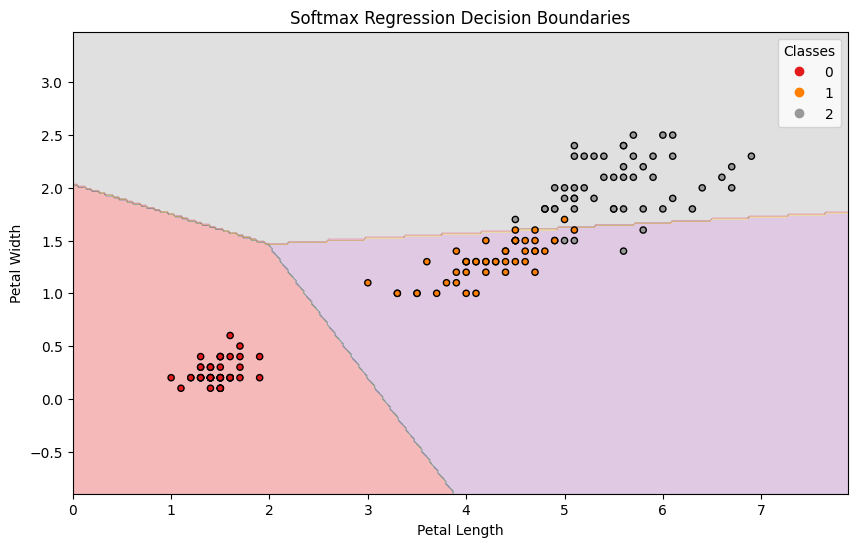

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


def predict_proba(X_test, theta):
    """Computes the softmax scores for given data and theta."""
    z = X_test.dot(theta)
    exp_z = np.exp(z - np.max(z, axis=1, keepdims=True))
    y_hat = exp_z / np.sum(exp_z, axis=1, keepdims=True)
    return y_hat

def predict_class(X_test, theta):
    """Predicts the class label based on the highest softmax score."""
    return np.argmax(predict_proba(X_test, theta), axis=1)

# Create a meshgrid for plotting
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                     np.arange(y_min, y_max, 0.02))

# Predict the class for each point in the meshgrid
grid_points = np.c_[xx.ravel(), yy.ravel()]
grid_points = np.hstack([grid_points, np.ones((grid_points.shape[0], 1))]) # Add bias column
Z = predict_class(grid_points, theta)
Z = Z.reshape(xx.shape)

# Plot the decision boundaries
plt.figure(figsize=(10, 6))
plt.contourf(xx, yy, Z, alpha=0.3, cmap=plt.cm.Set1)

# Plot the training points
scatter = plt.scatter(X[:, 0], X[:, 1], c=Y, cmap=plt.cm.Set1, edgecolor='k', s=20)
plt.xlabel('Petal Length')
plt.ylabel('Petal Width')
plt.title('Softmax Regression Decision Boundaries')
plt.legend(*scatter.legend_elements(), title="Classes")
plt.show()


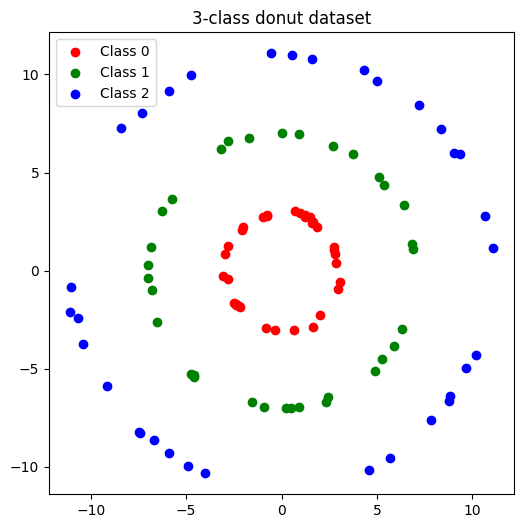

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(42)

def make_3class_donut(n_samples, radii):
    """
    Tạo dataset 3 lớp donut đồng tâm:
    - n_samples: tổng số mẫu (chia đều 3 lớp)
    - radii: list hoặc tuple 3 phần tử, bán kính vòng tròn cho 3 lớp

    Trả về X (n_samples, 2), y (n_samples,)
    """
    n_samples_per_class = n_samples // 3
    X_list = []
    y_list = []

    for i, r in enumerate(radii):
        theta = 2 * np.pi * np.random.rand(n_samples_per_class)
        r_noise = r + 0.1 * np.random.randn(n_samples_per_class)
        x = np.c_[r_noise * np.cos(theta), r_noise * np.sin(theta)]
        X_list.append(x)
        y_list.append(np.ones(n_samples_per_class) * i)

    X = np.vstack(X_list)
    y = np.hstack(y_list)
    return X, y

# Ví dụ: 100 mẫu, 3 lớp vòng tròn bán kính 3, 7, 11
X, y = make_3class_donut(99, (3, 7, 11))

# Vẽ dataset
plt.figure(figsize=(6,6))
colors = ['r', 'g', 'b']
labels = ['Class 0', 'Class 1', 'Class 2']
for i in range(3):
    plt.scatter(X[y==i][:,0], X[y==i][:,1], color=colors[i], label=labels[i])
plt.legend()
plt.title("3-class donut dataset")
plt.show()


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


data = pd.read_csv("Iris.csv")
data = data.to_numpy()
#X = data[:,2:4]
#Y = data[:,4]
X, Y = make_3class_donut(240, (3, 7, 11))

N = 240
X = np.hstack([X.reshape(-1,2), np.ones((N, 1))])
d = int(X.shape[1])
k = np.unique(Y).shape[0]

# one_hot
def convert_one_hot(y, k):
    one_hot = np.zeros((len(y), k))
    y = y.astype(int)
    one_hot[np.arange(len(y)), y] = 1
    return one_hot


theta = 0.01 * np.random.randn(d, k)
print('theta:\n', theta)


learning_rate = 0.01
losses = []
accs = []
epoch = 3000
m = 25


def predict(xi, theta):
    z = xi.dot(theta)
    exp_z = np.exp(z - np.max(z, axis=1, keepdims=True))
    y_hat = exp_z / np.sum(exp_z, axis=1, keepdims=True)
    return np.argmax(y_hat, axis=1)


for _ in range(epoch):
    shuffled_indices = np.random.permutation(N)
    X_b_shuffled     = X[shuffled_indices]
    y_shuffled       = Y[shuffled_indices]

    for i in range(0, N, m):
        xi = X_b_shuffled[i:i + m]
        yi = y_shuffled[i:i + m].reshape(-1,1)
        yi_one_hot = convert_one_hot(yi.flatten(), k)
        z = xi.dot(theta)

        exp_z = np.exp(z - np.max(z, axis=1, keepdims=True))
        y_hat = exp_z / np.sum(exp_z, axis=1, keepdims=True)


        loss = -np.sum(yi_one_hot * np.log(y_hat + 1e-10), axis=1)
        losses.append(np.mean(loss))


        gradient = xi.T.dot((y_hat - yi_one_hot)) / yi_one_hot.shape[0]
        theta -= learning_rate * gradient


        preds = predict(xi, theta)
        acc = (preds == yi.flatten().astype(int)).mean()
        accs.append(acc)

print(theta)

theta:
 [[-0.0232472   0.00180531  0.02643572]
 [-0.00202846  0.00046915  0.01782164]
 [ 0.00590275  0.00216861  0.00442117]]
[[ 0.00367602  0.02165378 -0.02033597]
 [-0.02270241 -0.01922013  0.05818487]
 [ 0.02283135  0.02342578 -0.03376461]]


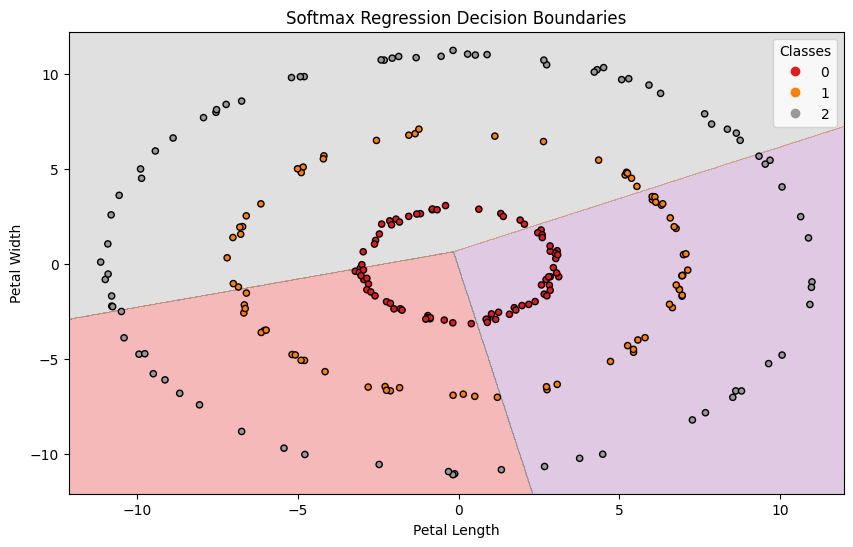

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


def predict_proba(X_test, theta):
    """Computes the softmax scores for given data and theta."""
    z = X_test.dot(theta)
    exp_z = np.exp(z - np.max(z, axis=1, keepdims=True))
    y_hat = exp_z / np.sum(exp_z, axis=1, keepdims=True)
    return y_hat

def predict_class(X_test, theta):
    """Predicts the class label based on the highest softmax score."""
    return np.argmax(predict_proba(X_test, theta), axis=1)

# Create a meshgrid for plotting
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                     np.arange(y_min, y_max, 0.02))

# Predict the class for each point in the meshgrid
grid_points = np.c_[xx.ravel(), yy.ravel()]
grid_points = np.hstack([grid_points, np.ones((grid_points.shape[0], 1))]) # Add bias column
Z = predict_class(grid_points, theta)
Z = Z.reshape(xx.shape)

# Plot the decision boundaries
plt.figure(figsize=(10, 6))
plt.contourf(xx, yy, Z, alpha=0.3, cmap=plt.cm.Set1)

# Plot the training points
scatter = plt.scatter(X[:, 0], X[:, 1], c=Y, cmap=plt.cm.Set1, edgecolor='k', s=20)
plt.xlabel('Petal Length')
plt.ylabel('Petal Width')
plt.title('Softmax Regression Decision Boundaries')
plt.legend(*scatter.legend_elements(), title="Classes")
plt.show()
